## *<font color = yellow> Notebook 1: </font>* LOCAL Zodiac Data Download - 
**This script includes the following:** <br> 
1. **Uploading Data** <br>
    *Please ensure that you adjusted the below edit block to your computer's <font color = magenta> directory </font>*
    - Data is pulled from your local python directory into this notebook
    - ALL DATA is compiled into respective arrays: lat, lon, sst, fluorimetry, etc...

2. **Data Processing / Figure Generation** <br>
    - Data is processed in the following ways:
        - Confined within the greater Santa Monica Bay (**SMB**)
        - All latitude and longitude coordinates are convereted from DMS to DD format
        **This is level 1 data - simply confined to region of interest and in proper format**
    - Figures are generated to illustrate:
        - The total amount of paths traversed by the Zodiac over all uploaded years 
        - The frequency of times zodiac visits select regions, resolved by 1.5km$^2$ bins about SMB only

3. **Saving Data**
    - Data is saved as .PKL files into two main dictionaries:
        - `track_data`: Each cruise is an individual key, embedded within are that cruises respective GPS coords and measured values 
        - `binned_track_data`: Same as one before, but with infomration on what 1.5km$^2$ bins the Zodiac passes through
        
<font color = yellow> **Code is organized based on the three sections defined above, with <font color = magenta> parameter </font> definitions below** </font>

In [22]:
# --------- Edit Code --------- #

# Directory to grab data #
gen_directory = 'C:\\Users\\gmanh\\OneDrive\\Documents\\UCLA\\SMB Ocean Weather\\New Surface Sampler Data\\'
# old_directroy = 'C:\\Users\\gmanh\\OneDrive\\Documents\\UCLA\\SMB Ocean Weather\\Surface Sampler Data\\'


#### Emplyed Libraries

In [3]:
### Necessary Imports for Code ###
import glob as glob # file sorting 
import numpy as np # Importing data from txt. format into array, `np.loadtxt`
import locale # Used in data import loop

### 1. Upload Data

In [4]:
# All years that we have data 
### THAT IS WE HAVE DATA FROM ALL THESE YEARS IN OUR PYTHON FOLDER, LOCALLY SAVED ###
### IF NOT, USE GOOGLE SCRIPT TO ADD MORE DATA FROM DRIVE ###
year = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
SSD_ALL = []
oldSSD_ALL = []

# Append name of data directories via loop # 
for y in range(len(year)):
    specific_year = year[y]
    directory_path = f"{gen_directory}{specific_year}"
    File = glob.glob(directory_path + '/[kds]*')
    File.sort() 
    SSD_ALL = np.append(SSD_ALL, File)
    
print(f'Number of files uploaded: {len(SSD_ALL)}')

# Denote index in which data changes format #
for i in range(len(SSD_ALL)):
    file_date = SSD_ALL[i][91:99] 
    if file_date == '20170601':
        format_change_index = i
        break

Number of files uploaded: 648


In [5]:
# First define empty arrays to append to consecutively add imported data to
latitude = np.array([])
longitude = np.array([])
dates = np.array([])
SST = np.array([])       # Sea Surface Temperature
flu = np.array([])       # Fluorometry 

# if something goes wrong this array will store name of file which failed
bad_files = np.array([])

# Now do a looped read using
for i in range(len(SSD_ALL)): 
    # There are a few bad files that prevent the loop from running, to avoid this, we can use a try statement
    # It will at first try the following code 
    try: 
        # print(SSD_ALL[i])
        # Starting june 1st of 2017, txt files change formatting. So to ensure we upload coloumns properly we check if our data
        # is before or after the data above
        if i < format_change_index:
            date_of_cruise, SST_str, flu_str, long_str, lat_str = np.loadtxt(SSD_ALL[i], dtype = str,
                                   usecols = (0,5,8,2,3), unpack = True)
            # Let us sort the date, such that it does not include commas
            cruise_date = np.array([])
            for j in range(len(date_of_cruise)):
                # We splice from 0 to 6 to get the simple year, month, day string 
                time = date_of_cruise[j][0:6]
                cruise_date = np.append(cruise_date, time)
        else: 
            date_of_cruise, SST_str, flu_str, long_str, lat_str = np.loadtxt(SSD_ALL[i], dtype = str,
                                   usecols = (0,8,11,3,4), unpack = True)
            cruise_date = np.array([])
            for j in range(len(date_of_cruise)):
                # We spilce from 0 to 8 if it is greater than 63, as after the 63rd file the format for recording
                # date changed to including the full year (2017 versus just 17)
                time = date_of_cruise[j][0:8]
                cruise_date = np.append(cruise_date, time)
        # selects the respective file from the list of files SSD_2015, then pulls from 
        # cols to add to respective arrays long_str and lat_str
        lat_fixed_array = []
        long_fixed_array = []
        SST_fixed_array = []
        flu_fixed_array = []
        # To fix the fact they are strings with commas, use locale imported above
        for k in range(len(long_str)):
            locale.setlocale(locale.LC_ALL, '')
            lat_fixed = locale.atof(lat_str[k]) # for each value remove comma and make float
            long_fixed = locale.atof(long_str[k]) # assigns fixed value to variable
            SST_fixed = locale.atof(SST_str[k])
            flu_fixed = locale.atof(flu_str[k])
            # with the fixed variables add them to a new array
            lat_fixed_array = np.append(lat_fixed_array, lat_fixed)
            long_fixed_array = np.append(long_fixed_array, long_fixed)
            SST_fixed_array = np.append(SST_fixed_array, SST_fixed)
            flu_fixed_array = np.append(flu_fixed_array, flu_fixed)
            # With the fixed arrays for each file, append to arrays that contains
            # lat and long coordinate for all of cruises! 
        latitude = np.append(latitude, lat_fixed_array)
        longitude = np.append(longitude, long_fixed_array)
        dates = np.append(dates, cruise_date)
        SST = np.append(SST, SST_fixed_array)
        flu = np.append(flu, flu_fixed_array)
    # If the file is no good, it will assign that to a variable and add it to an array
    except:
        no_good = SSD_ALL[i]
        # call this array to see what files are no good, and use length to check how many bad ones there are 
        bad_files = np.append(bad_files, no_good)
    # Continue means run next iteration of loop 
    continue

### 2. Data Organization 

In [6]:
# We will restric longitude data within -120 and -117 (SoCal Bight)
# Boolean Arugument
santa_monica_longitude_range = ((longitude > -120) & (longitude < -117.0))
# Apply this to the longitude data
lon_range = longitude[santa_monica_longitude_range]

# Before setting up a latitude range, we need to ensure that the lengths of the two arrays remain the same 
# To do this, we will normalize the latitude data to the longitude data. This will select the ith values of the 
# lat array that correspond with the ith arrays of the longitude array, such that they are of equal length
normalized_lat_range = latitude[santa_monica_longitude_range]

# Now slice this data for SoCal Bight parameters 
santa_monica_latitude_range = ((normalized_lat_range > 32) & (normalized_lat_range < 35))
lat_range = normalized_lat_range[santa_monica_latitude_range]

# Make sure we get the corresponding dates 
all_dates = dates[santa_monica_longitude_range]
all_SST = SST[santa_monica_longitude_range]
all_flu = flu[santa_monica_longitude_range]

# Check that this worked!
len(lat_range) == len(lon_range) == len(all_dates) == len(all_SST) == len(all_flu)

True

**ALSO,** some data is not in degree decimal form, so below we convert into DD from DMS

In [7]:
### CONVERSIONS ###

# date of scheme change is 20170601, so find this index
change = np.where(all_dates == '20170601')[0][0]

# CONVERSION FOR LATITUDE
for j in range(len(lat_range)):
    lattitude_position = lat_range[j]
    if j < change:
        if lattitude_position < 34:
            lattitude_string = str(lattitude_position)
            # Now for conversion we must seperate first three indices (degrees and decimal places)
            # This takes the decimal vals 
            lattitude_minute_decimal = lattitude_string[3:-1] + lattitude_string[-1]
            # Convert these to an integer to perform operations on them for conversion
            lattitude_minute_decimal_int = int(lattitude_minute_decimal)
            # Convert to decimals by dividing by 60, as 60 sec = 1 minute
            lattitude_degree_converted = lattitude_minute_decimal_int//60 # Do // to eliminate remainder
            # convert this to a string to add the first three indices back on, the degree location (ex. 33 or 34) and the '.'
            lattitude_degree_string = str(lattitude_degree_converted)
            lattitude_decimal_degrees_string = lattitude_string[0:3] + lattitude_degree_string
            # Convert to float 
            lat_deg_dec = float(lattitude_decimal_degrees_string)
            # Append to array
            lat_range[j] = lat_deg_dec
        else:
            lat_range[j] = lattitude_position
    else:
        lat_range[j] = lattitude_position

# CONVERSION FOR LONGITUDE
for j in range(len(lon_range)):
    longitude_position = lon_range[j]
    if j < change:
        longitude_string = str(longitude_position)
        # Now for conversion we must seperate first three indices (degrees and decimal places)
        # This takes the decimal vals 
        longitude_minute_decimal = longitude_string[5:-1] + longitude_string[-1]
        # Convert these to an integer to perform operations on them for conversion
        longitude_minute_decimal_int = int(longitude_minute_decimal)
        # Convert to decimals by dividing by 60, as 60 sec = 1 minute
        longitude_degree_converted = longitude_minute_decimal_int//60 # Do // to eliminate remainder
        # convert this to a string to add the first three indices back on, the degree location (ex. 33 or 34) and the '.'
        longitude_degree_string = str(longitude_degree_converted)
        longitude_decimal_degrees_string = longitude_string[0:5] + longitude_degree_string
        # Convert to float 
        lon_deg_dec = float(longitude_decimal_degrees_string)
        # Append to array
        lon_range[j] = lon_deg_dec
    else: 
        lon_range[j] = longitude_position

In [8]:
# Test lengths of latitude and longitude arrays:
print(f'The lengths of lon and lat are: {len(lon_range)}')

# Check range of lat and lon
print(f'Longitude maximums and minimums are: {max(lon_range)}, {min(lon_range)}')
print(f'Latitude maximums and minimums are: {max(lat_range)}, {min(lat_range)}')
print(f'Temperature max and mins are: {max(all_SST)}, {min(all_SST)}')

The lengths of lon and lat are: 3537311
Longitude maximums and minimums are: -118.053687, -118.939998
Latitude maximums and minimums are: 34.0452243914, 33.290353
Temperature max and mins are: 33.7593, 0.8931


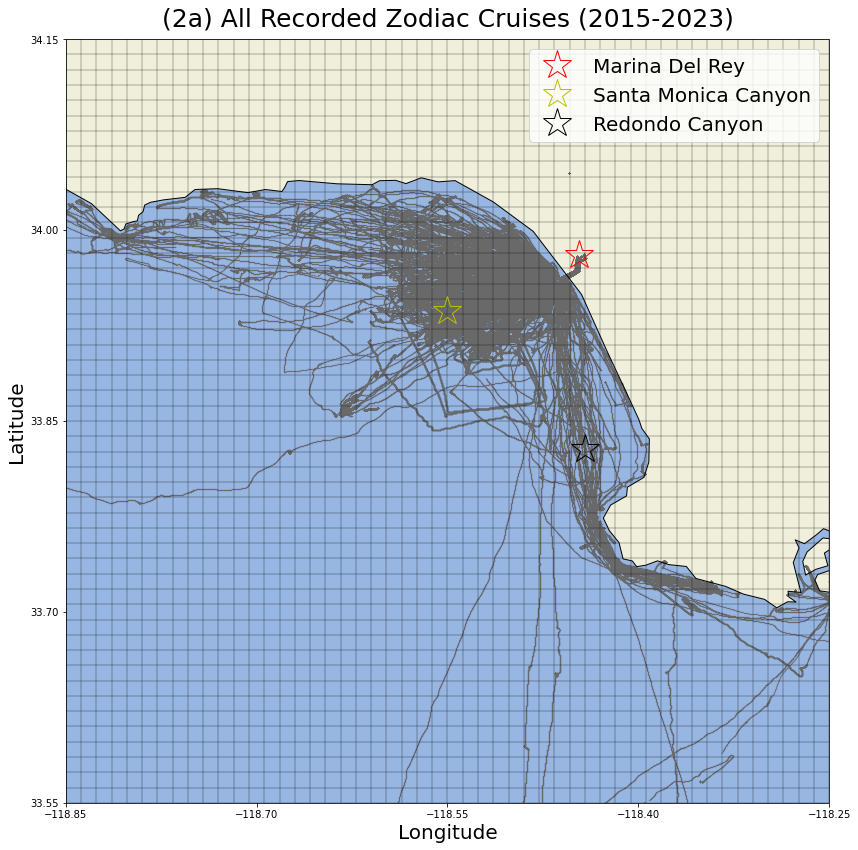

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib import cm
from matplotlib import colors
# Mapping
import cartopy
import cartopy.crs as ccrs #importing the cartopy coordinate reference system library
import cartopy.feature as cfeature #importing the cartopy library of surface features

import zodiacfunctions as zf

# Figure and variable assesment
fig1 = plt.figure(1, (14,12))
fig1.patch.set_facecolor('white')
long_lat_coords = [-118.85, -118.25, 33.55, 34.15]  

# Set up map/projection and dimensions
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.set_extent(long_lat_coords) # Will restrict map to above coordinate domain
ax.coastlines()

lat_min = 33.55
lat_max = 34.15
lon_min = -118.85
lon_max = -118.25

# Split this range into 50 bins, use 51 as linspace is non-inclusive
lat = np.linspace(lat_min, lat_max, 51)
lon = np.linspace(lon_min, lon_max, 51)

### CHECK that respective bin sizes for lon and latitude are ~50 ###
lon_size = ((max(lon) - min(lon))/(lon[1]-lon[0]))
lat_size = ((max(lat) - min(lat))/(lat[1]-lat[0]))

bins = 51


# Plot 
plt.scatter(lon_range, lat_range, s = .01, color = 'dimgrey')

# Add grid
zf.meshed_gird(lat_min, lat_max, lon_min, lon_max, bins)

# Add details to plot
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# # Notable Features 
plt.plot(-118.446948, 33.980090,'r*', markerfacecolor = 'none', markersize = 30, label = 'Marina Del Rey')
plt.plot(-118.550683, 33.936375,'y*', markerfacecolor = 'none', markersize = 30, label = 'Santa Monica Canyon')
plt.plot(-118.442027, 33.828203,'k*', markerfacecolor = 'none', markersize = 30, label = 'Redondo Canyon')

# Add some labels 
plt.suptitle('(2a) All Recorded Zodiac Cruises (2015-2023)', fontsize = 25)
ax.set_xticks(np.linspace(-118.85, -118.25, 5),crs=ccrs.PlateCarree()) #set x-ticks
ax.set_yticks(np.linspace(33.55, 34.15, 5),crs=ccrs.PlateCarree()) #set y-ticks 
plt.xlabel('Longitude', fontsize = 20)
plt.ylabel('Latitude', fontsize = 20)
plt.legend(fontsize = 20, loc = 'upper right')

plt.tight_layout()

#plt.savefig("ZodiacTracks.png", dpi = 150)

In [14]:
############################################### Count Bins #########################################################

### This loop will count how many times the zodiac enters a bin, only counting a specific bin once per day to avoid
### conflation of zodiac presence in predicted high frequency areas, harbor mouth

# This code is a string generator and will so forth be used to get consecutive dates
# First define string arrays to pull from in our loop that will concatenate together dates
year_strings = ['15', '16', '17', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
#####
months_of_year = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] 
#####
days_of_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                 '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                 '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

latitudes = np.array([])
longitudes = np.array([])

actual_dates = np.array([])

# Now start loop
# First select a year
for y in range(len(year_strings)):
    year = year_strings[y]
    # With year, get a month
    for m in range(len(months_of_year)):
        month = months_of_year[m]
        # finally get respective day of month of some year
        for d in range(len(days_of_month)):
            day = days_of_month[d]
            # In 2017 the txt files begun storing the data as year month day, not day month year; these conditionals 
            # account for said switch 
            if y < 3:
                date = day+month+year
            else:
                date = year+month+day
            # Grab all indices in our data that correspond with our date
            date_selector = (all_dates == date)
            needed_date = all_dates[date_selector]
            respective_lat = lat_range[date_selector]
            respective_lon = lon_range[date_selector]
            # If there are suffcient amounts of data for that date, meaning it is a date we actually went out, continue 
            if respective_lat.size > 0:
                actual_dates = np.append(actual_dates, date)
                # This will now run through the lat array that splits our data into 100 bins 
                for i in range(len(lat) - 1): 
                    # Latitude Limit
                    lower_lim_y = lat[i] 
                    upper_lim_y = lat[i + 1]
                    # With our limits select all data that fits into the row 
                    row = (respective_lat >= lower_lim_y) & (respective_lat < upper_lim_y)
                    lat_in_row = respective_lat[row]
                    # Grab corresponding longitude data
                    lon_in_row = respective_lon[row]
                    # Only if there are multiple points that the zodiac was in this row can we continue
                    if (len(lat_in_row) > 1):
                        # Now run through each longitude or coloumn in our row 
                        for j in range(len(lon) - 1):
                            lower_lim_x = lon[j]
                            upper_lim_x = lon[j + 1]
                            test = (lon_in_row >= lower_lim_x) & (lon_in_row < upper_lim_x)
                            long = lon_in_row[test]
                            # If there are plenty of longitude points, then we mark this bin 
                            if (len(long) > 1):
                                # We mark the bin by grabbing the mid point of the respective bin 
                                point_lat = .5*(lower_lim_y + upper_lim_y)
                                point_lon = .5*(lower_lim_x + upper_lim_x)
                                # Add said bin to an array 
                                latitudes = np.append(latitudes, point_lat)
                                longitudes = np.append(longitudes, point_lon)

print(longitudes, latitudes)

[-118.448 -118.436 -118.448 ... -118.46  -118.448 -118.448] [33.82  33.82  33.832 ... 33.964 33.964 33.976]


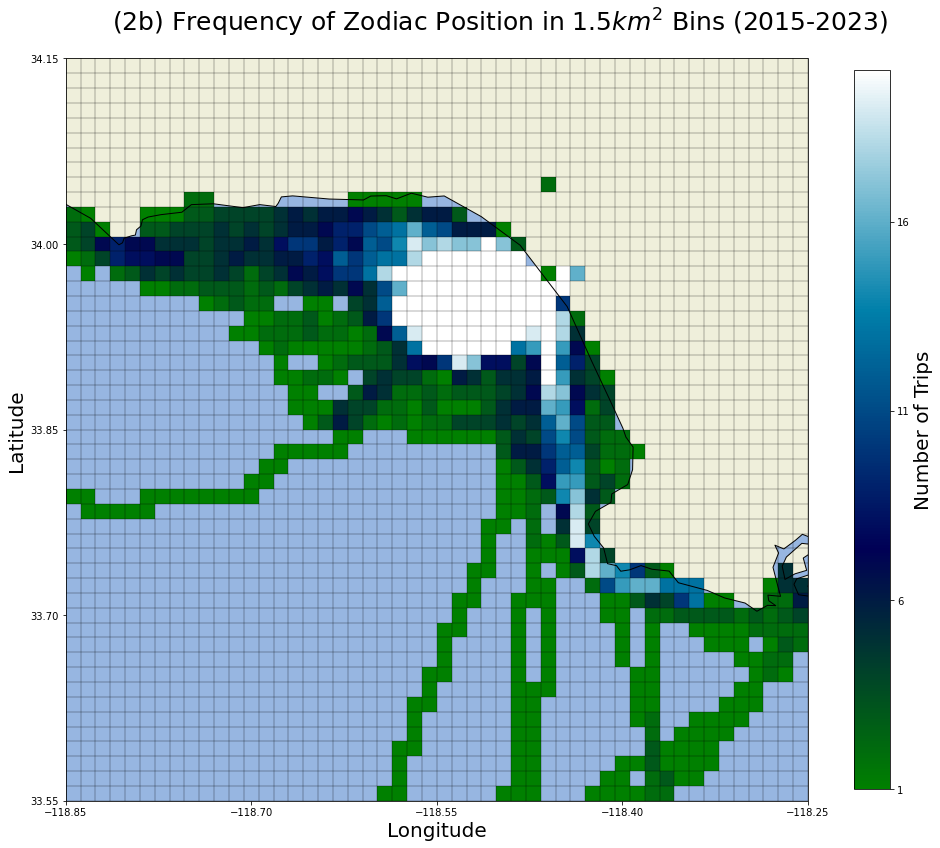

In [15]:
# Figure and variable assesment
fig2 = plt.figure(1, (14,12))
fig2.patch.set_facecolor('white')
long_lat_coords = [-118.85, -118.25, 33.55, 34.15]  

# Set up map/projection and dimensions
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.set_extent(long_lat_coords) # Will restrict map to above coordinate domain
ax.coastlines()

# Plot Histogram 
plt.hist2d(longitudes, latitudes, bins=(50,50),
           range = [(-118.85, -118.25), (33.55, 34.15)],
           cmap=cm.ocean, cmin = 1, vmin = 1, vmax = 20)
plt.colorbar(shrink = .93, ticks = np.arange(1, 21, 5)).set_label('Number of Trips', fontsize = 20)

# Add grid
zf.meshed_gird(lat_min, lat_max, lon_min, lon_max, bins)

# Add details to plot
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Add some labels 
plt.suptitle('(2b) Frequency of Zodiac Position in $1.5 km^2$ Bins (2015-2023)', fontsize = 25)
ax.set_xticks(np.linspace(-118.85, -118.25, 5),crs=ccrs.PlateCarree()) #set x-ticks
ax.set_yticks(np.linspace(33.55, 34.15, 5),crs=ccrs.PlateCarree()) #set y-ticks 
plt.xlabel('Longitude', fontsize = 20)
plt.ylabel('Latitude', fontsize = 20)

plt.tight_layout()

#plt.savefig("ZodiacPositionFrequency.png", dpi = 150)

### 3. Save Data

#### 3a. Dictionaries
The below script will take the above arrays and sort them into two dictionaries: <br>
1). `Cruise` = A dictionary that can you can use the `data_selector` function with the parameters 'date_of_cruise' (date of specific cruise) and 'bin_location' to get the lat., lon., and SST arrays for a specific bin on a specifc cruise/date! <br>
2). `Track` = A dictionary that you can use `track_selector` function with parameters 'date_of_cruise' to get all of the lat., lon., and SST arrays for a specific cruise - **does not select a bin but rather the entire cruise.**

In [16]:
# Create 'bins' for the data to be spliced into
lat = np.linspace(33.55, 34.15, 51)
lon = np.linspace(-118.85, -118.25, 51)

print(lat, '\n', lon)

[33.55  33.562 33.574 33.586 33.598 33.61  33.622 33.634 33.646 33.658
 33.67  33.682 33.694 33.706 33.718 33.73  33.742 33.754 33.766 33.778
 33.79  33.802 33.814 33.826 33.838 33.85  33.862 33.874 33.886 33.898
 33.91  33.922 33.934 33.946 33.958 33.97  33.982 33.994 34.006 34.018
 34.03  34.042 34.054 34.066 34.078 34.09  34.102 34.114 34.126 34.138
 34.15 ] 
 [-118.85  -118.838 -118.826 -118.814 -118.802 -118.79  -118.778 -118.766
 -118.754 -118.742 -118.73  -118.718 -118.706 -118.694 -118.682 -118.67
 -118.658 -118.646 -118.634 -118.622 -118.61  -118.598 -118.586 -118.574
 -118.562 -118.55  -118.538 -118.526 -118.514 -118.502 -118.49  -118.478
 -118.466 -118.454 -118.442 -118.43  -118.418 -118.406 -118.394 -118.382
 -118.37  -118.358 -118.346 -118.334 -118.322 -118.31  -118.298 -118.286
 -118.274 -118.262 -118.25 ]


In [17]:
# This code is a string generator and will so forth be used to get consecutive dates
# First define string arrays to pull from in our loop that will concatenate together dates
year_strings = ['15', '16', '17', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
#####
months_of_year = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] 
#####
days_of_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                 '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                 '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

latitudes = np.array([])
longitudes = np.array([])

actual_dates = np.array([])

cruise_bins = {}
track = {}

# Now start loop
# First select a year
for y in range(len(year_strings)):
    year = year_strings[y]
    # With year, get a month
    for m in range(len(months_of_year)):
        month = months_of_year[m]
        # finally get respective day of month of some year
        for d in range(len(days_of_month)):
            day = days_of_month[d]
            # In 2017 the txt files begun storing the data as year month day, not day month year; these conditionals 
            # account for said switch 
            if y < 3:
                date = day+month+year
            else:
                date = year+month+day
            # Grab all indices in our data that correspond with our date
            date_selector = (all_dates == date)
            needed_date = all_dates[date_selector]
            respective_lat = lat_range[date_selector]
            respective_lon = lon_range[date_selector]
            respective_SST = all_SST[date_selector]
            ### FLU ###
            resepctive_flu = all_flu[date_selector]
            ###     ###
            # If there are suffcient amounts of data for that date, meaning it is a date we actually went out, continue 
            if respective_lat.size > 0:
                # First add the data into the track dictionary 
                #specific_track = {'location': (respective_lon, respective_lat), 'SST': (respective_SST)}
                ### FLU ###
                specific_track = {'location': (respective_lon, respective_lat), 'SST': (respective_SST), 'Flu': (resepctive_flu)}
                ###     ###
                track[date] = specific_track
                actual_dates = np.append(actual_dates, date)
                # This will now run through the lat array that splits our data into 100 bins 
                bin_dict = {}
                for i in range(len(lat) - 1): 
                    # Latitude Limit
                    lower_lim_y = lat[i] 
                    upper_lim_y = lat[i + 1]
                    # With our limits select all data that fits into the row 
                    row = (respective_lat >= lower_lim_y) & (respective_lat < upper_lim_y)
                    lat_in_row = respective_lat[row]
                    # Grab corresponding longitude data
                    lon_in_row = respective_lon[row]
                    # and sst
                    SST_in_row = respective_SST[row]
                    ### FLU ###
                    flu_in_row = resepctive_flu[row]
                    ###     ###
                    # run through each coloumn in row getting us to each bin 
                    # also record this row
                    bin_row = i+1
                    if (len(lat_in_row) > 1):
                        for j in range(len(lon) - 1):
                            loc_dict = {}
                            lower_lim_x = lon[j]
                            upper_lim_x = lon[j + 1]
                            test = (lon_in_row >= lower_lim_x) & (lon_in_row < upper_lim_x)
                            long = lon_in_row[test]
                            lati = lat_in_row[test]
                            SST = SST_in_row[test]
                            ### FLU ###
                            flu = flu_in_row
                            ###     ###
                            if (len(long) > 1):
                            # record this bins coloumn
                                bin_col = j+1
                                specific_bin = (f'bin_{bin_row}_{bin_col}')
                                ### FLU ###
                                # loc_dict = {'location': (long, lati), 'SST': (SST)}
                                loc_dict = {'location': (long, lati), 'SST': (SST), 'Fluorometry': (flu)}
                                ###     ###
                                bin_dict[specific_bin] = loc_dict
                                cruise_bins[date] = bin_dict

# print(lat_in_row, long)

#### 3b. *Pickle* Files
Pickle files allow us to save data and reupload it in other scripts with minimal effort. For more information, click [here](https://pynative.com/python-save-dictionary-to-file/).

In [18]:
import pickle

# save `track` dictionary to zodiac_track_data.pkl file
with open('track_data.pkl', 'wb') as ztd:
    pickle.dump(track, ztd)
    print('dictionary saved successfully to file')
    
# save `cruise_bins` dictionary to zodiac_binned_data.pkl file
with open('binned_track_data.pkl', 'wb') as zbd:
    pickle.dump(cruise_bins, zbd)
    print('dictionary saved successfully to file')

dictionary saved successfully to file
dictionary saved successfully to file


### Results

In [19]:
print(f' --- Diagnostics of Upload --- \nNumber of Files Uploaded: {len(SSD_ALL)} \nIndividual Cruises: {len(actual_dates)}'+
      f'\nNumber of Corrupted Files: {len(bad_files)}')

 --- Diagnostics of Upload --- 
Number of Files Uploaded: 648 
Individual Cruises: 222
Number of Corrupted Files: 61


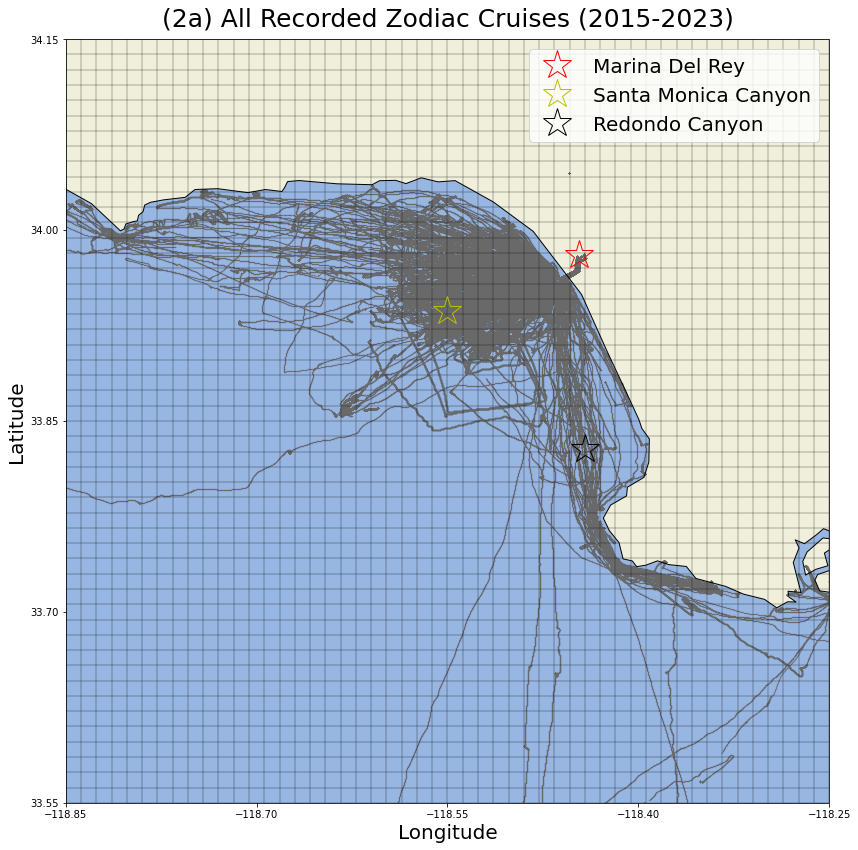

In [20]:
fig1

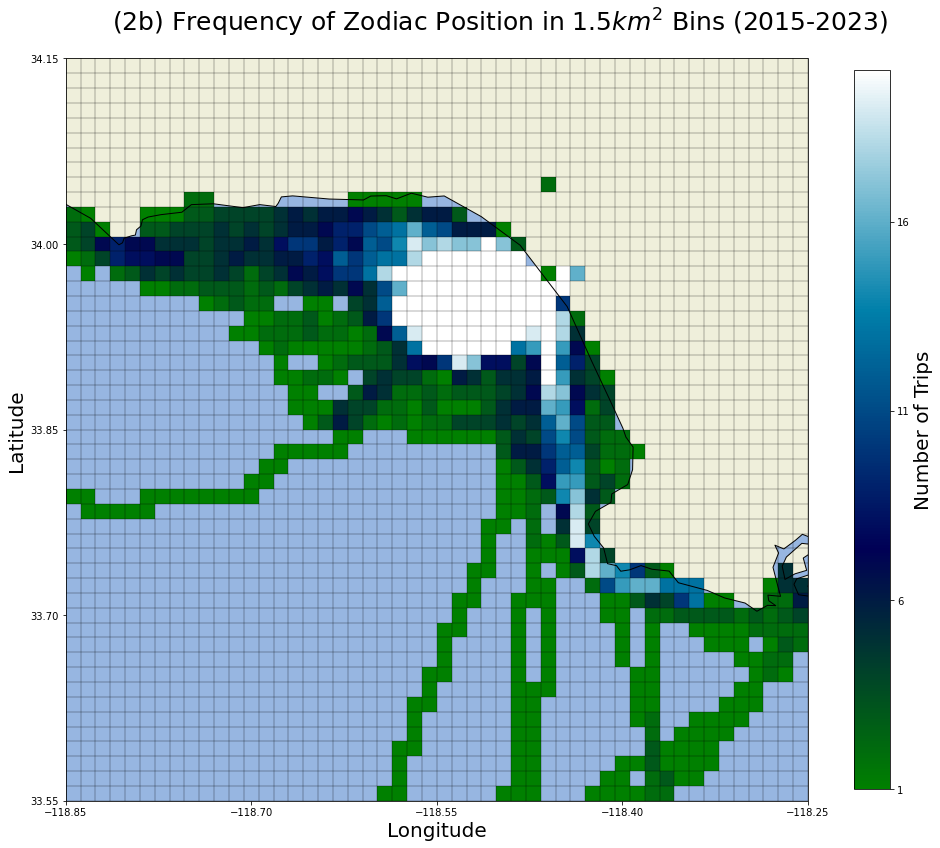

In [21]:
fig2